# Shadow Index Part2 documentation
In this document, I aim to compare my hedge strategy for russian feedwheat, comparing to Matif weekly index.

In [1]:
import pandas as pd
import numpy as np
import datetime 
import os
import matplotlib.pyplot as plt
%matplotlib inline
maturity=4
full_maturity=int(maturity*8.5)

In [2]:
''' convert daily data to weekly frequency '''
this_df=pd.read_csv('C:/Users/richard/Documents/stable/algorithm hedging/step 2/additional_index/RU1.csv',index_col=0)
Matif=pd.read_csv('C:/Users/richard/Documents/stable/algorithm hedging/step 2/additional_index/Matif.csv',index_col=0)
cattle=pd.read_csv('C:/Users/richard/Documents/stable/algorithm hedging/step 2/additional_index/daily 2001 cattle active futures.csv',index_col=0)
petro=pd.read_excel('C:/Users/richard/Documents/stable/algorithm hedging/step 2/additional_index/daily 2004 petroleum active future.xlsx',index_col=0)
daily=pd.read_csv('C:/Users/richard/Documents/stable/algorithm hedging/step 2/additional_index/daily_index.csv',index_col=0)
Matif.index = pd.DatetimeIndex(Matif.index,dayfirst=True)
this_df.index = pd.DatetimeIndex(this_df.index,dayfirst=True)
cattle.index = pd.DatetimeIndex(cattle.index,dayfirst=True)
petro.index = pd.DatetimeIndex(petro.index,dayfirst=False)
daily.index = pd.DatetimeIndex(daily.index,dayfirst=True)
this_df=this_df.join(Matif, how='inner')
this_df=this_df.join(cattle, how='inner')
this_df=this_df.join(petro, how='inner')
this_df=this_df.join(daily, how='inner')


In [3]:
this_df.index

DatetimeIndex(['2008-01-02', '2008-01-09', '2008-01-16', '2008-01-18',
               '2008-01-23', '2008-01-25', '2008-01-30', '2008-02-01',
               '2008-02-06', '2008-02-08',
               ...
               '2019-02-15', '2019-02-22', '2019-03-04', '2019-03-07',
               '2019-03-18', '2019-03-22', '2019-04-01', '2019-04-05',
               '2019-04-12', '2019-04-26'],
              dtype='datetime64[ns]', length=746, freq=None)

In [4]:
idx = pd.date_range('2001-01-01', '2019-04-30')
exchange=pd.read_excel('C:/Users/richard/Documents/stable/algorithm hedging/exchange1.xlsx',index_col=0)
exchange=exchange.reindex(idx)
def fillnadata(dataset):
    for ii,i in enumerate(dataset.index):
        for jj,j in enumerate(dataset):
            if str(dataset.iloc[ii,jj])=='nan':
                try:
                    if str(dataset.iloc[ii+1,jj])=='nan':
                        dataset.iloc[ii,jj]=dataset.iloc[ii-1,jj]
                    else:
                        dataset.iloc[ii,jj]=(dataset.iloc[ii-1,jj]+dataset.iloc[ii+1,jj])/2
                except:
                    dataset.iloc[ii,jj]=dataset.iloc[ii-1,jj]
    return dataset
exchange=fillnadata(exchange)
idx= pd.DatetimeIndex(this_df.index)
exchange=exchange.reindex(idx)
this_df.loc[:,'WRU1']=this_df.loc[:,'WRU1'].divide(exchange.iloc[:,0].values)
this_df.to_csv('C:/Users/richard/Documents/stable/algorithm hedging/step 2/Final_index.csv')

In [5]:
this_df=pd.read_csv('C:/Users/richard/Documents/stable/algorithm hedging/step 2/Final_index.csv',index_col=0)
weekly_return_ratio=(this_df.iloc[full_maturity:,:]-this_df.iloc[:-full_maturity,:].values).divide(this_df.iloc[:-full_maturity,:].values)

In [6]:
from dtw import dtw
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import norm
from numpy import array
import matplotlib.pyplot as plt
import datetime
from fastdtw import fastdtw
import seaborn as sns
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr
import operator
sns.set_style("whitegrid", {'font_scale':0.9,
                           'font.scale':0.9,
                           'xtick.color':'#A5A5A5',
                           'ytick.color':'#A5A5A5',
                           'text.color': '#424242',
                           'legend.frameon': True})
def show_case_dtw(return_ratio,a,b):
    x = array(return_ratio.iloc[:,a]).reshape(-1, 1)
    y = array(return_ratio.iloc[:,b]).reshape(-1, 1)
    print(list(return_ratio)[a])
    print(list(return_ratio)[b])
    plt.figure(figsize=(10,5))
    plt.plot(return_ratio.index,x)
    plt.plot(return_ratio.index,y)
    plt.title('Future Return Rate', fontsize=22)
    plt.show()

    dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))
    # acc.T is the accumulated cost matrix returned from the dtw( ) function.
    # origin is which part of the chart to start the plot.
    # cmap is shorthand for color map. The 'prism' palette is particularly useful for visualizing DTW outputs.
    plt.figure(figsize=(10.3,10.3))
    plt.imshow(acc.T, origin='lower', cmap='tab20c', interpolation='nearest')
    plt.title('Cummulative Distance', fontsize=22)
    plt.plot(path[0], path[1], 'w')
    plt.xlim((-0.5, acc.shape[0]-0.5))
    plt.ylim((-0.5, acc.shape[1]-0.5))
    plt.colorbar()
    plt.show()
    plt.clf() # Clear the current figure in-case we want to generate or try a different plot.
    print(dist)
    return None
#show_case_dtw(weekly_return_ratio,0,1)

In [7]:
Y=weekly_return_ratio.iloc[:,0]
array_1=array(Y).reshape(-1, 1)
final_return_ratio=weekly_return_ratio.drop(weekly_return_ratio.columns[0], axis=1)

In [8]:
DTW_dist    =  {}
ED_dist     =  {}
Cor_dist    =  {}
ROI_dist    =  {}
def discrete(x):
    x1=[]
    for i in x:
        if i>0.05 and i<0.2:
            x1.append(1)
        elif i<-0.05 and i>-0.2:
            x1.append(-1)
        elif i>=0.2:
            x1.append(2)
        elif i<=-0.2:
            x1.append(-2)
        else:
            x1.append(0)
    return x1

''' as clustering is not a necessacity, just find the closest few datas '''
for n,item in enumerate(list(final_return_ratio)):
    y = array(final_return_ratio.loc[:,item]).reshape(-1, 1)
    distance, path = fastdtw(array_1, y, dist=lambda x, y: norm(x - y, ord=1))
    DTW_dist[item] = distance
    ED_dist[item]  = euclidean(array_1,y)
    Cor_dist[item] = pearsonr(array_1,y)
    ROI_dist[item] = euclidean(discrete(array_1),discrete(y))
    print(f"\r Finished {n} columns",end="")    
sorted_DTW_dist = dict(sorted(DTW_dist.items(), key=operator.itemgetter(1),reverse=False))
sorted_ED_dist = dict(sorted(ED_dist.items(), key=operator.itemgetter(1),reverse=False))
sorted_Cor_dist = dict(sorted(Cor_dist.items(), key=operator.itemgetter(1),reverse=True))
sorted_ROI_dist = dict(sorted(ROI_dist.items(), key=operator.itemgetter(1),reverse=False))

 Finished 414 columns

MATIF-CORN CONTINUOUS - SETT. PRICE - E /TE    PCOCS00    E
Matif
Cc1    CORN SEP9/d
CBT-CORN COMP. C.2ND.LT - SETT. PRICE    CCFCS21    UC
CBT-CORN COMP. CONTINUOUS WVOL - SETT. PRICE - UC/BL    CCFCS02    UC
LWBc1    WHEAT B NOV9/d
EMAc1    MAIZE EUR NOV9/d
BL2c3    M.WHEAT EUR MA/d
CBT-CORN COMP. C.2ND.FT - SETT. PRICE    CCFCS20    UC
CBT-CORN COMP. TRc2 - SETT. PRICE - UC/BC    CCFC.02    UC
CBT-CORN COMP. CONTINUOUS LTDT - SETT. PRICE - UC/BL    CCFCS01    UC
MATIF-CORN CONTINUOUS INDEX - SETT. PRICE - E /TE    PCOCS04    E
COMc2    RAPESEED EU FE/d
BL2c5    M.WHEAT EUR SE/d
BL2c1    M.WHEAT EUR SE/d
CBT-CORN COMP. CONTINUOUS VOL - SETT. PRICE - UC/BL    CCFCS03    UC
Wc1    WHEAT SRW SEP9/d
Total 17 futures choosed


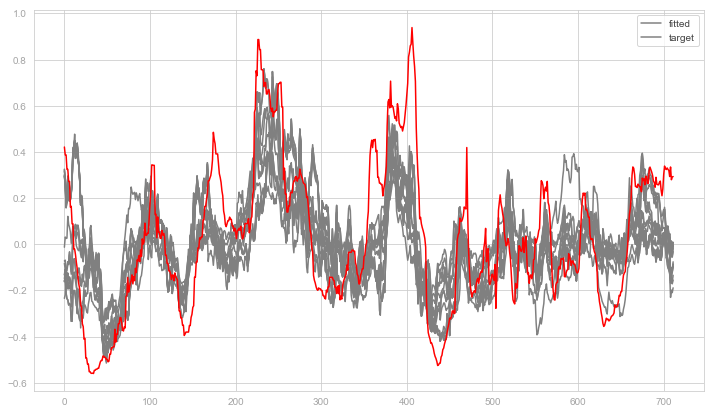

In [9]:
result=list(sorted_DTW_dist.keys())[:7]+list(sorted_ED_dist.keys())[:7]+list(sorted_Cor_dist.keys())[:7]+list(sorted_ROI_dist.keys())[:7]
result=list(set(result))
# this shows our choices of relevant future options
for i in result:
    print(i)
print(f'Total {len(result)} futures choosed')
# a sample price movement of one of choosed index and target index 

plt.figure(figsize=(12,7))
plt.plot(final_return_ratio.loc[:,result[:]].values,color='grey')
plt.plot(Y.values,color='red')
plt.legend(['fitted','target'])

In [10]:
''' create our training data'''
final_df1=final_return_ratio.loc[:,result]
final_df1['Y']=Y.values
clipped_df=final_df1.clip(-0.3, 0.3)

Train_X1 = final_df1.iloc[200:,:-1]
Train_Y1 = final_df1.iloc[200:,-1]
Test_X1  = final_df1.iloc[:,:-1]
Test_Y1  = final_df1.iloc[:,-1]

Train_X2 = clipped_df.iloc[200:,:-1]
Train_Y2 = clipped_df.iloc[200:,-1]
Test_X2  = final_df1.iloc[:,:-1]
Test_Y2  = final_df1.iloc[:,-1]

[1.34, 0.65, -0.0, 0.03, 1.27, -0.2, -0.85, -0.59, 0.27, 0.03, -0.0, 0.33, -0.43, 0.14, 0.65, -1.56, 0.03]
[0.91, 0.72, -0.09, -0.23, 2.16, -0.2, -0.72, -0.62, -0.78, -0.23, -0.09, 0.27, 0.04, -0.36, 0.72, -0.81, 0.18]


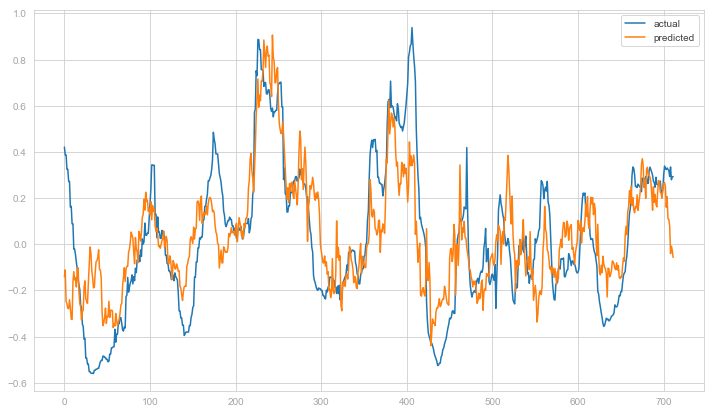

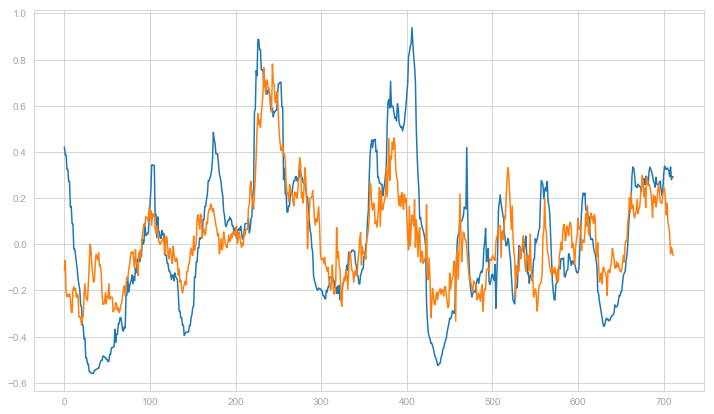

In [11]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression(normalize=True)
linreg.fit(Train_X1,Train_Y1)
y_pred = linreg.predict(Test_X1)
plt.figure(figsize=(12,7))
plt.plot(Test_Y1.values)
plt.plot(y_pred)
plt.legend(['actual','predicted'])
# Here i clipped the upper/lower price change rates to avoid exteme price movement
linreg2 = LinearRegression(normalize=True)
linreg2.fit(Train_X2,Train_Y2)
y_pred2 = linreg2.predict(Test_X2)
plt.figure(figsize=(12,7))
plt.plot(Test_Y2.values)
plt.plot(y_pred2)
print([round(i,2) for i in linreg.coef_])
print([round(i,2) for i in linreg2.coef_])

['MATIF-CORN CONTINUOUS - SETT. PRICE - E /TE    PCOCS00    E',
 'Matif',
 'Cc1    CORN SEP9/d',
 'CBT-CORN COMP. C.2ND.LT - SETT. PRICE    CCFCS21    UC',
 'CBT-CORN COMP. CONTINUOUS WVOL - SETT. PRICE - UC/BL    CCFCS02    UC',
 'LWBc1    WHEAT B NOV9/d',
 'EMAc1    MAIZE EUR NOV9/d',
 'BL2c3    M.WHEAT EUR MA/d',
 'CBT-CORN COMP. C.2ND.FT - SETT. PRICE    CCFCS20    UC',
 'CBT-CORN COMP. TRc2 - SETT. PRICE - UC/BC    CCFC.02    UC',
 'CBT-CORN COMP. CONTINUOUS LTDT - SETT. PRICE - UC/BL    CCFCS01    UC',
 'MATIF-CORN CONTINUOUS INDEX - SETT. PRICE - E /TE    PCOCS04    E',
 'COMc2    RAPESEED EU FE/d',
 'BL2c5    M.WHEAT EUR SE/d',
 'BL2c1    M.WHEAT EUR SE/d',
 'CBT-CORN COMP. CONTINUOUS VOL - SETT. PRICE - UC/BL    CCFCS03    UC',
 'Wc1    WHEAT SRW SEP9/d',
 'Y']

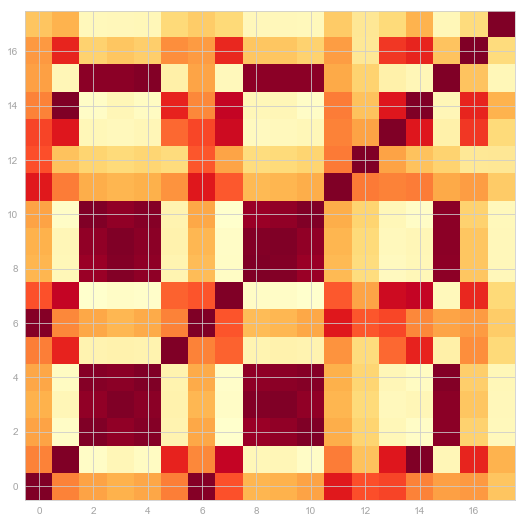

In [12]:
plt.figure(figsize=(9,9))
plt.imshow(final_df1.corr(), origin='lower', cmap='YlOrRd', interpolation='nearest')
'''From result, we can remove 0,1,3,5,10,12,15'''
list(final_df1)

3
[False  True False False  True False False False False False False False
 False False False  True False]
[ 2  1 14 12  1  9  3  6  8 11 15  7  5 10  4  1 13]


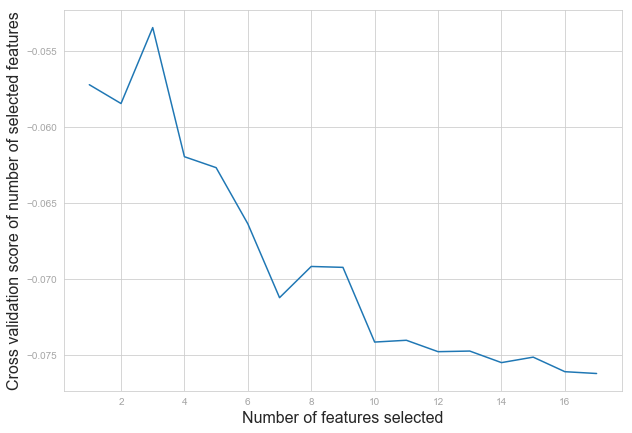

'0,1,2,5,10,15 '

In [13]:
from sklearn.feature_selection import RFECV
# Create recursive feature eliminator that scores features by mean squared errors
ols=LinearRegression(normalize=True)
rfecv = RFECV(estimator=ols, step=1, scoring='neg_mean_squared_error',cv=5)

# Fit recursive feature eliminator 
rfecv.fit(Train_X1, Train_Y1)
# Recursive feature elimination
rfecv.transform(Train_X1)
print(rfecv.n_features_)
print(rfecv.support_)
print(rfecv.ranking_)
plt.figure(figsize=(10,7))
plt.xlabel("Number of features selected",fontsize=16)
plt.ylabel("Cross validation score of number of selected features",fontsize=16)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

selected_1=[]
for n,i in enumerate(list(final_df1.iloc[50:,:-1])):
    if rfecv.support_[n]==True:
        selected_1.append(i)
selected_1
'''0,1,4,6,15 '''

Feature ranking:
1. feature 1 (0.294208)
2. feature 14 (0.265660)
3. feature 16 (0.085453)
4. feature 15 (0.073577)
5. feature 7 (0.050261)
6. feature 12 (0.046970)
7. feature 5 (0.038546)
8. feature 11 (0.031156)
9. feature 4 (0.024617)
10. feature 13 (0.020223)
11. feature 8 (0.015818)
12. feature 0 (0.012625)
13. feature 6 (0.012213)
14. feature 2 (0.009603)
15. feature 3 (0.007667)
16. feature 9 (0.006238)
17. feature 10 (0.005163)


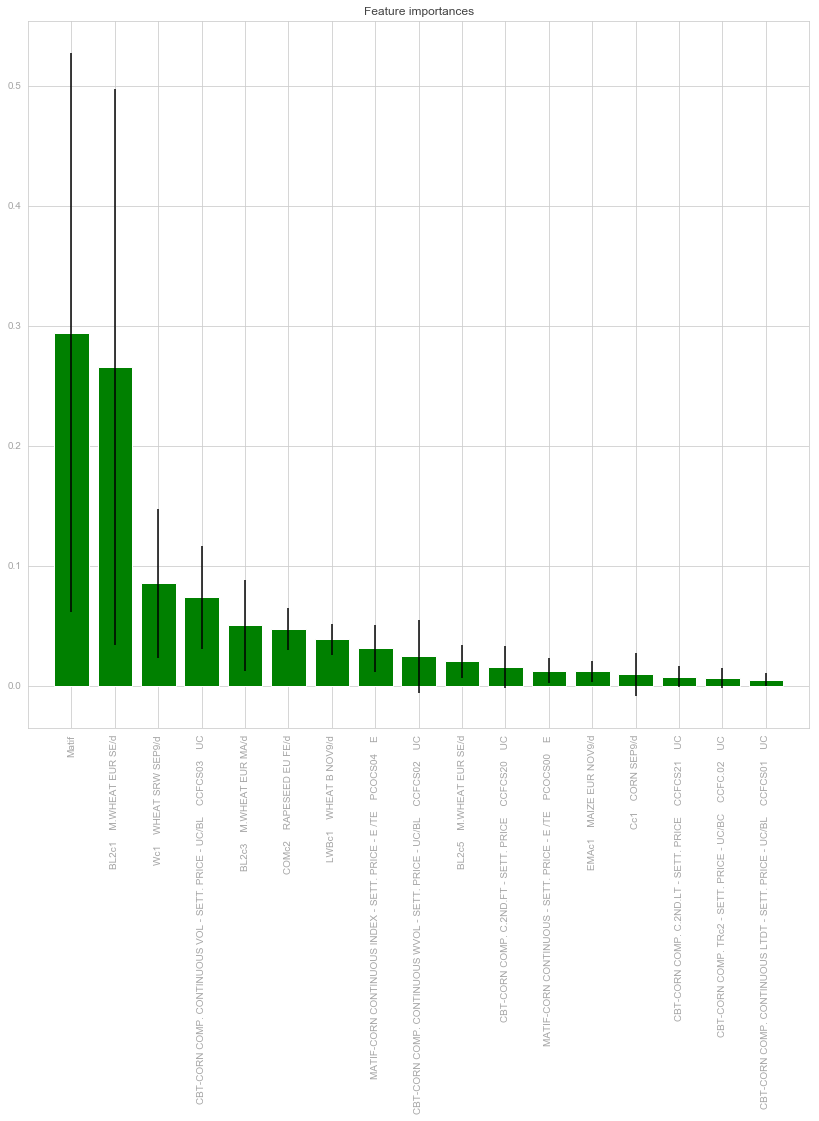

In [21]:
from sklearn.ensemble import RandomForestRegressor
clf_rf = RandomForestRegressor(n_estimators=100)   
clr_rf = clf_rf.fit(Train_X1,Train_Y1)
importances = clr_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(Train_X1.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(Train_X1.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(Train_X1.shape[1]),Train_X1.columns[indices],rotation=90)
plt.xlim([-1, Train_X1.shape[1]])
plt.show()

linear regression train score: 0.6431169708909762
linear regression test score: 0.5955527538195347
ridge regression train score low alpha: 0.6396982187880574
ridge regression test score low alpha: 0.5987983255489437
ridge regression train score high alpha: 0.5239778014751786
ridge regression test score high alpha: 0.5140471589361598


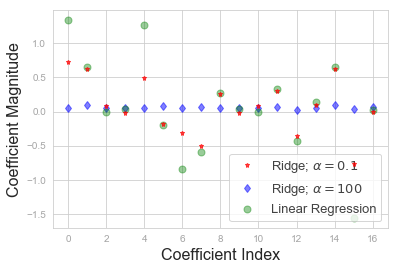

In [15]:
from sklearn.linear_model import Ridge

lr = LinearRegression()
lr.fit(Train_X1, Train_Y1)

rr = Ridge(alpha=0.1) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles
rr.fit(Train_X1, Train_Y1)

rr100 = Ridge(alpha=100) #  comparison with alpha value
rr100.fit(Train_X1, Train_Y1)

train_score=lr.score(Train_X1, Train_Y1)
test_score=lr.score(Test_X1, Test_Y1)

Ridge_train_score = rr.score(Train_X1, Train_Y1)
Ridge_test_score = rr.score(Test_X1, Test_Y1)
Ridge_train_score100 = rr100.score(Train_X1, Train_Y1)
Ridge_test_score100 = rr100.score(Test_X1, Test_Y1)
print ("linear regression train score:", train_score)
print ("linear regression test score:", test_score)
print ("ridge regression train score low alpha:", Ridge_train_score)
print ("ridge regression test score low alpha:", Ridge_test_score)
print ("ridge regression train score high alpha:", Ridge_train_score100)
print ("ridge regression test score high alpha:", Ridge_test_score100)
plt.plot(rr.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.1$',zorder=7) # zorder for ordering the markers
plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 100$') # alpha here is for transparency
plt.plot(lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()


[ 0.73215908  0.63025747  0.08478593 -0.02194335  0.49000247 -0.18387226
 -0.3198555  -0.4995019   0.25228942 -0.02194335  0.08478593  0.30293285
 -0.3657779   0.09335263  0.63025747 -0.76981148 -0.00758376]


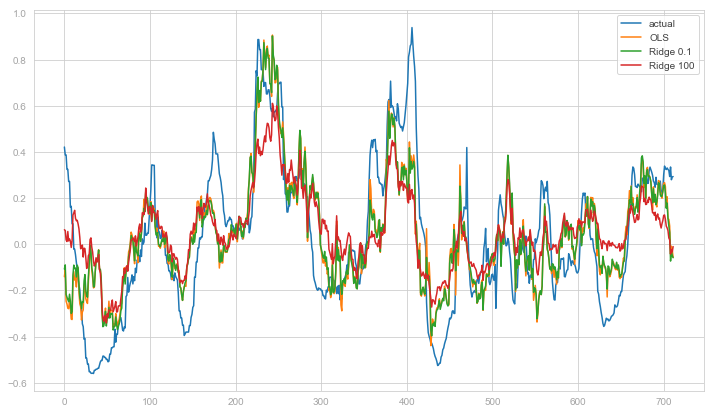

In [16]:
y_pred1=lr.predict(Test_X1)
y_pred2=rr.predict(Test_X1)
y_pred3=rr100.predict(Test_X1)
plt.figure(figsize=(12,7))
plt.plot(Test_Y1.values)
plt.plot(y_pred1)
plt.plot(y_pred2)

    
plt.plot(y_pred3)
plt.legend(['actual','OLS','Ridge 0.1','Ridge 100'])
print(rr.coef_)

C:\Users\richard\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
C:\Users\richard\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:478: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\richard\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Text(0.5, 1.0, 'Number of Coefficients')

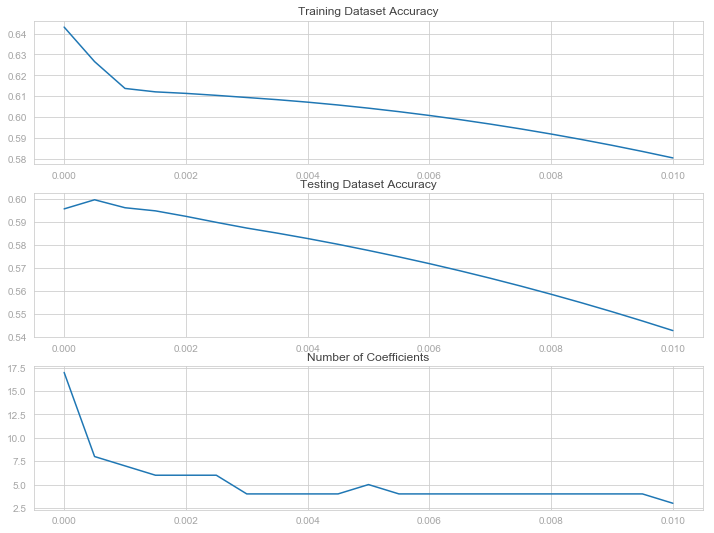

In [17]:
from sklearn.linear_model import Lasso
train_score,test_score,coeff_used=[],[],[]
alphas=[0.0005*i for i in range(21)]
for alpha in alphas:
    lasso = Lasso(alpha, max_iter=10e5)
    lasso.fit(Train_X1, Train_Y1)
    train_score.append(lasso.score(Train_X1, Train_Y1))
    test_score.append(lasso.score(Test_X1, Test_Y1))
    coeff_used.append(np.sum(lasso.coef_!=0))

plt.figure(figsize=(12,9))
plt.subplot(3,1,1)
plt.plot(alphas,train_score) 
plt.title('Training Dataset Accuracy')
plt.subplot(3,1,2)
plt.plot(alphas,test_score) 
plt.title('Testing Dataset Accuracy')
plt.subplot(3,1,3)
plt.plot(alphas,coeff_used) 
plt.title('Number of Coefficients')

[ 0.0360211   0.82893728  0.09723325  0.          0.0586882   0.
  0.          0.          0.          0.          0.          0.16935861
 -0.          0.          0.00187257  0.          0.        ]


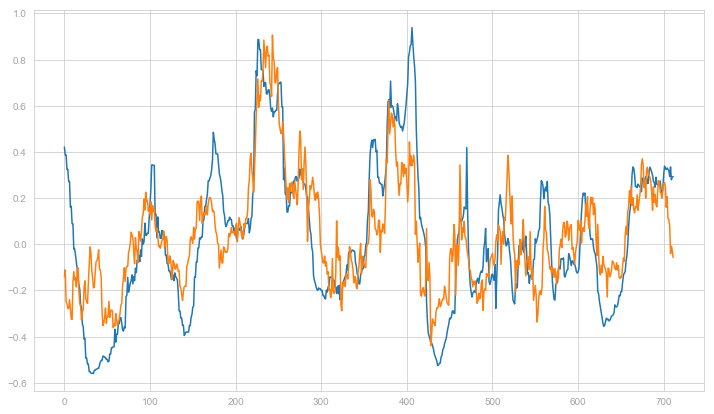

In [18]:
lasso = Lasso(0.002, max_iter=10e7)
lasso.fit(Train_X1, Train_Y1)
print(lasso.coef_)
y_pred=lasso.predict(Test_X1)
plt.figure(figsize=(12,7))
plt.plot(Test_Y1.values)
plt.plot(y_pred1)



Selected Future contracts are:
MATIF-CORN CONTINUOUS - SETT. PRICE - E /TE    PCOCS00    E
Matif
Cc1    CORN SEP9/d
CBT-CORN COMP. CONTINUOUS WVOL - SETT. PRICE - UC/BL    CCFCS02    UC
BL2c1    M.WHEAT EUR SE/d

[ 0.46394391  0.3451958  -0.18222207  0.4230068   0.3451958 ] [ 0.45267591  0.34733281 -0.06202329  0.30641695  0.34733281]


C:\Users\richard\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


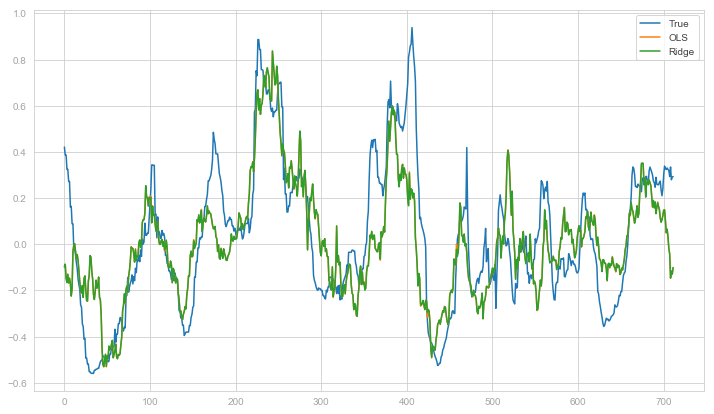

In [22]:
def train_with_selection(cols,alpha):
    final_df1 = final_return_ratio.loc[:,result]
    filtered_df1 = final_df1.iloc[:,cols]
    filtered_df1['Y'] =Y.values


    Train_X1 = filtered_df1.iloc[:-50,:-1]
    Train_Y1 = filtered_df1.iloc[:-50,-1]
    Test_X1  = filtered_df1.iloc[:,:-1]
    Test_Y1  = filtered_df1.iloc[:,-1]
    linreg = LinearRegression()
    linreg.fit(Train_X1,Train_Y1)
    #y_pred = linreg.predict(Test_X1)
    y_pred = Test_X1.values.dot(linreg.coef_)

    rr = Ridge(alpha) 
    rr.fit(Train_X1, Train_Y1)
    #y_pred2 = rr.predict(Test_X1)
    y_pred2 = Test_X1.values.dot(rr.coef_)
    
    plt.figure(figsize=(12,7))
    plt.plot(Test_Y1.values)
    plt.plot(y_pred)
    plt.plot(y_pred2)
    plt.legend(['True','OLS','Ridge'])
    print('')
    print('Selected Future contracts are:')
    for i in list(filtered_df1)[:-1]:
        print(i)
    print('')
    return linreg,rr,y_pred2
# linreg1,rr1,y_pred1=train_with_selection([2,5,6,10,8],10)
# print(linreg1.coef_,rr1.coef_)
linreg2,rr2,y_pred2=train_with_selection([0,1,2,4,14],0.1)
print(linreg2.coef_,rr2.coef_)

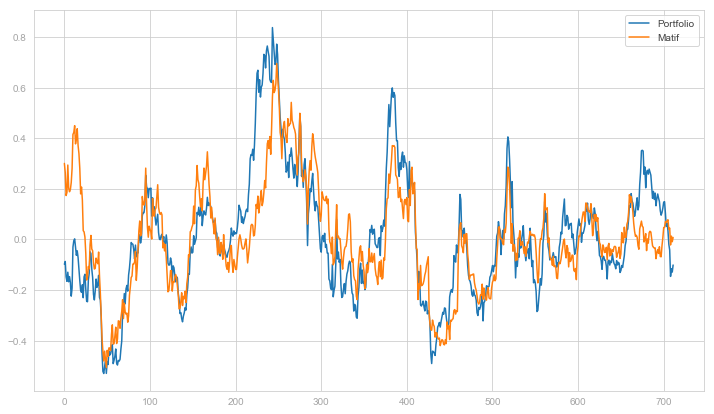

In [23]:
plt.figure(figsize=(12,7))
plt.plot(y_pred2)
plt.plot(Test_X1.iloc[:,2].values)
plt.legend(['Portfolio','Matif'])
plt.show()

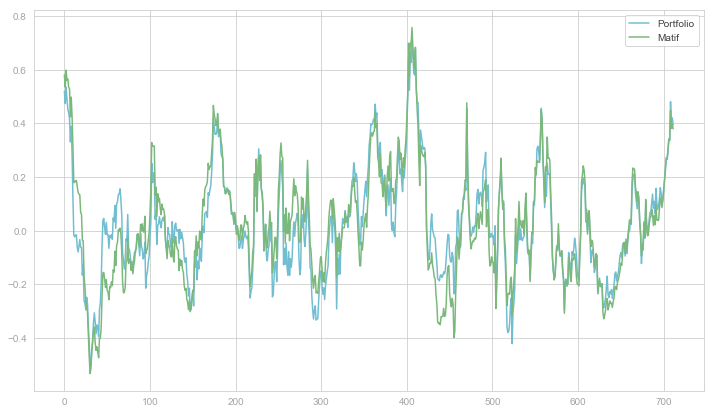

In [24]:

plt.figure(figsize=(12,7))
plt.plot(Y.values-y_pred2,color='#71bed1')
plt.plot(Y.values-Test_X1.loc[:,'Matif'].values,color='#7bb87b')
#plt.plot(Y.values,color='#888888')
plt.legend(['Portfolio','Matif','actual'][:-1])
plt.show()

In [25]:
print( np.mean(Y.values-y_pred2)                        )
print( np.mean(Y.values-Test_X1.loc[:,'Matif'].values)  )
print( np.std(Y.values-y_pred2)                        )
print( np.std(Y.values-Test_X1.loc[:,'Matif'].values)  )


0.019453215137889113
0.021132935628736912
0.197427397366452
0.21266552582625461


----
# Part 2: Cost-profit analysis
### We first try to calculate total payoff of RU3 without hedging to act like reference

In [27]:
this_df=pd.read_csv('C:/Users/richard/Documents/stable/algorithm hedging/step 2/Final_index.csv',index_col=0)
r=0.0054/12
loss_ratio=0.65
columns=[0,1,2,4,14]
selected_df=this_df.loc[:,result]
selected_df=selected_df.iloc[:,columns]
selected_df['Y']=this_df.iloc[:,0]

# convert price into return ratio
maturity_return_ratio=(selected_df.iloc[full_maturity:,:]-selected_df.iloc[:-full_maturity,:].values).divide(selected_df.iloc[:-full_maturity,:].values)
daily_return_ratio=(selected_df.iloc[1:,:]-selected_df.iloc[:-1,:].values).divide(selected_df.iloc[:-1,:].values)


# set up possible stop and strike ratio
strike_ratio_list = np.arange(0.96,0.74, -0.02)
strike_ratio_list = [round(i,2) for i in strike_ratio_list]
stop_ratio_list   = strike_ratio_list[::-1]
expansion         = [1 for i in strike_ratio_list]



this_index            =  selected_df.loc[:,'Y'].values
start_price           =  this_index[:-full_maturity]
end_price             =  this_index[full_maturity:]
end_price_list        =  np.outer(end_price,expansion)

premium_ratio_table   =  {}
for stop_step,this_stop in enumerate(stop_ratio_list):
    stop_ratio_list=[round(this_stop,2) for i in strike_ratio_list]
    strike_price,stop_price=np.outer(start_price,strike_ratio_list),np.outer(start_price,stop_ratio_list)
    put_pay_off_1 = strike_price - end_price_list
    put_pay_off_2 = stop_price   - end_price_list
    put_pay_off_1=pd.DataFrame(put_pay_off_1);put_pay_off_2=pd.DataFrame(put_pay_off_2)
    put_pay_off_1[put_pay_off_1<=0]=0;put_pay_off_2[put_pay_off_2<=0]=0
    put_pay_off=put_pay_off_1-put_pay_off_2
    put_pay_off.columns=strike_ratio_list
    premium_ratio = []
    index_price_sum = np.sum(start_price)
    for i in strike_ratio_list:
        payoff_sum = np.sum(put_pay_off[i])
        premium = payoff_sum/(loss_ratio*index_price_sum) 
        premium_ratio.append(premium) #list- row of premium in certain stop ratio(20 strike ratios)
    premium_ratio_table[this_stop]=premium_ratio
premium_ratio_table=pd.DataFrame(index=strike_ratio_list,data=premium_ratio_table)
premium_ratio_table.index.name='Strike Ratio'
for i in range(len(premium_ratio_table)):
    premium_ratio_table.iloc[i,-(i+1):]=np.nan
premium_ratio_table

,0.76,0.78,0.8,0.82,0.84,0.86,0.88,0.9,0.92,0.94,0.96
Strike Ratio,,,,,,,,,,,
0.96,0.122393,0.114258,0.105523,0.095798,0.085109,0.073356,0.060294,0.046220,0.031482,0.016056,NaN
0.94,0.106336,0.098201,0.089466,0.079741,0.069052,0.057300,0.044237,0.030163,0.015426,NaN,NaN
0.92,0.090910,0.082775,0.074040,0.064315,0.053626,0.041874,0.028811,0.014737,NaN,NaN,NaN
0.90,0.076173,0.068038,0.059303,0.049578,0.038889,0.027137,0.014074,NaN,NaN,NaN,NaN
0.88,0.062099,0.053964,0.045229,0.035504,0.024815,0.013063,NaN,NaN,NaN,NaN,NaN
0.86,0.049036,0.040901,0.032166,0.022441,0.011752,NaN,NaN,NaN,NaN,NaN,NaN
0.84,0.037284,0.029149,0.020414,0.010689,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.82,0.026595,0.018460,0.009725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.80,0.016870,0.008735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate option price for choosed portfolio. 
The original Black–Scholes model has undergone several theoretical developments. One such development for the valuation of futures options is introduced by Black (1976). Black proposed a formula for options under the assumption that investors generate risk less hedges between options and the futures or forward contracts. The problem of negative cost of carry was addressed by using ‘forward prices’ in the option pricing model instead of ‘spot prices’. Black observed that actual forward prices not only incorporate cost of carry but also takes into account other irregularities in the market. In his proposed model, he substituted spot price (S) by the discounted value of future price (F.e-rt) in the original Black-Scholes model. Black’s model found application in valuing options on physical commodities where future price is a better alternative input for valuing options. The Call options prices as per Black’s formula can be observed solving following equation:
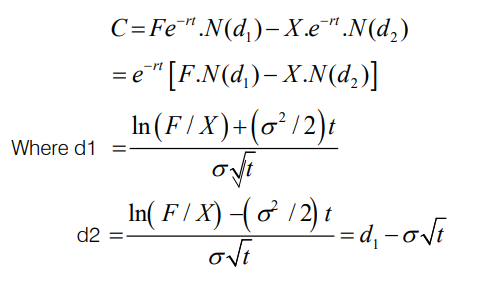
**In the formula F is the future price of the asset and other input parameters are similar to the inputs used in the Black-Scholes model.**

The past volatility of a security can be estimated as the standard deviation of a stock's returns over a predetermined number of days. Choosing the appropriate number of days is complicated. Longer period of observation has an averaging effect and as volatility varies with time and very old data may not be relevant for the current situation and can not be used for predicting the future. In absence of an agreed method to estimate volatility to be used in options pricing models, a simple method of estimating standard deviation using **past three months return** was used in the study. 
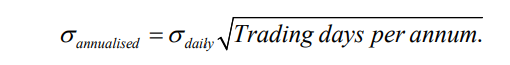

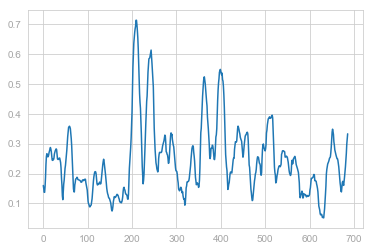

In [28]:

option1=final_df1.loc[:,'Matif']
final_df2=final_df1.iloc[25:,:]
price_movement=option1.values
length=len(price_movement)
base_volatility=[]
# calculate 3-month volatility
for i in range(length-25):
    base_volatility.append(np.std(price_movement[i:i+25]))
# convert weekly volatility to monthly volatility, average 8.5 data points per month
base_volatility=np.array(base_volatility)*np.sqrt(8.5)
plt.plot(base_volatility)

In [29]:
'''Calculate volatility for all products selected'''
dic={}
for name in list(daily_return_ratio):
    option1=daily_return_ratio.loc[:,name]
    price_movement=option1.values
    length=len(price_movement)
    base_volatility=[]
    # calculate 3-month volatility
    for i in range(length-25):
        base_volatility.append(np.std(price_movement[i:i+25]))
    # convert weekly volatility to monthly volatility, average 8.5 data points per month
    base_volatility=np.array(base_volatility)*np.sqrt(8.5)
    dic[name]=base_volatility
    stored_volatility=pd.DataFrame(data=dic,index=daily_return_ratio.index[25:])
    print(name)
stored_volatility=stored_volatility.loc[maturity_return_ratio.index,:]

MATIF-CORN CONTINUOUS - SETT. PRICE - E /TE    PCOCS00    E
Matif
Cc1    CORN SEP9/d
CBT-CORN COMP. CONTINUOUS WVOL - SETT. PRICE - UC/BL    CCFCS02    UC
BL2c1    M.WHEAT EUR SE/d
Y


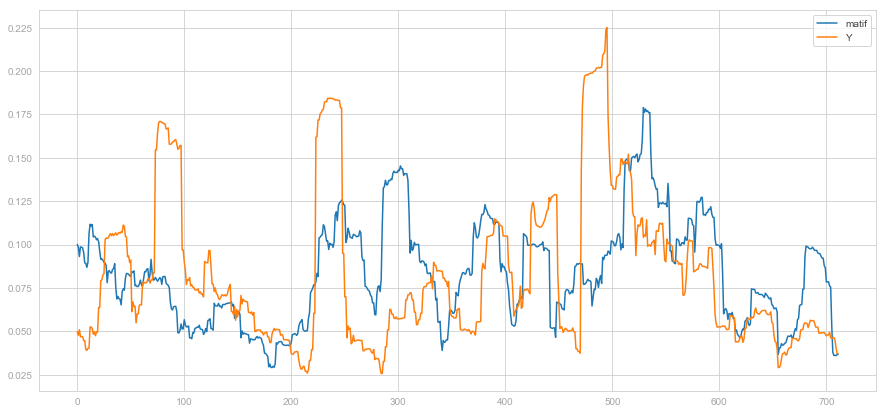

In [30]:
#plt.plot((this_df.loc[:,'WRU1']).divide(this_df.loc[:,'Matif'].values).values)
plt.figure(figsize=(15,7))
plt.plot(stored_volatility.loc[:,'Matif'].values)
plt.plot(stored_volatility.loc[:,'Y'].values)
plt.legend(['matif','Y'])
plt.show()

### Hedging method and payoff calculation:
Take example of Russian Feedwheat: In this case we will hedge it by purchase a Matif put option, the payoff function is:

**Payoff_total = Payoff_RU3 - Payoff_Matif + Cost_matif_option**

In [31]:
import numpy as np
import scipy.stats as si
import sympy as sy

def euro_vanilla_call(F, K, T, r, sigma):
    
    #F: F is the future price of the asset 
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(F / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(F / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    call = (F * np.exp(-r * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call

def euro_vanilla_put(F, K, T, r, sigma):
    
    #F: F is the future price of the asset 
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(F / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(F / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    put = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - F * np.exp(-r * T) * si.norm.cdf(-d1, 0.0, 1.0))
    
    return put

### Data Structure and Shape
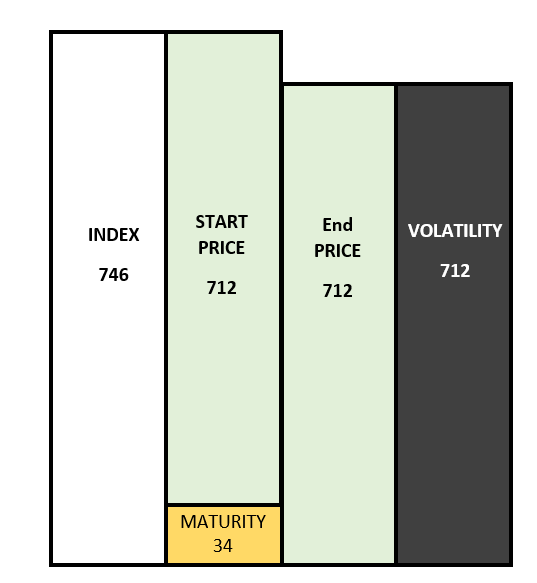

### Create function to generate option price that is dynamically changing

In [32]:
'''calculate option price'''
all_option_prices={}
futures=list(selected_df)[:-1]
for future in futures:
    hedge_index=selected_df.loc[:,future].values
    hedge_index_volatility=stored_volatility.loc[:,future].values
    option_price={}
    for this_strike in strike_ratio_list:
        this_option_price=[]
        for n_iter,volatility in enumerate(hedge_index_volatility):
            F = hedge_index[n_iter]   # future price
            K = F*this_strike         # strike price
            this_option_price.append(euro_vanilla_put(F , K, maturity, r, volatility)) # calculate put option price
        option_price[this_strike]=this_option_price
    all_option_prices[future]=option_price
# option price of different product have been saved into a dictionary
pd.DataFrame(data=all_option_prices['Matif'],index=stored_volatility.index)


,0.96,0.94,0.92,0.9,0.88,0.86,0.84,0.82,0.8,0.78,0.76
2008-05-07,15.496741,13.223833,11.166154,9.322246,7.688113,6.257200,5.020468,3.966573,3.082145,2.352162,1.760412
2008-05-12,14.421958,12.277120,10.339051,8.606114,7.074168,5.736560,4.584209,3.605804,2.788094,2.116280,1.574476
2008-05-14,13.413251,11.304738,9.414504,7.739759,6.274780,5.010961,3.936985,3.039134,2.301717,1.707600,1.238816
2008-05-16,14.651779,12.473919,10.505869,8.745975,7.190049,5.831351,4.660686,3.666590,2.835634,2.152816,1.602027
2008-05-21,14.630601,12.451913,10.483609,8.724000,7.168842,5.811333,4.642195,3.649879,2.820866,2.140062,1.591275
2008-05-23,14.647638,12.458569,10.481867,8.715761,7.155888,5.795283,4.624476,3.631700,2.803198,2.123637,1.576593
2008-05-28,13.804507,11.686654,9.781304,8.086206,6.596384,5.304148,4.199234,3.269053,2.499053,1.873190,1.374461
2008-05-30,12.739496,10.659330,8.805251,7.173544,5.757246,4.546246,3.527534,2.685614,2.003038,1.461056,1.040321
2008-06-04,14.068911,11.765647,9.713556,7.908449,6.342507,5.004401,3.879580,2.950727,2.198368,1.601598,1.138872
2008-06-06,13.914251,11.576454,9.502189,7.686359,6.119890,4.789897,3.680059,2.771171,2.041869,1.469471,1.030868


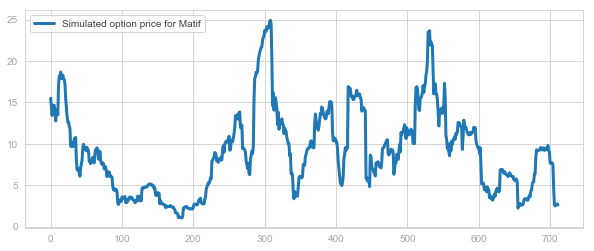

In [33]:
plt.figure(figsize=(10,4))
plt.plot(all_option_prices['Matif'][0.96],linewidth=3)
plt.legend(['Simulated option price for Matif'])

### Now calculate the hedged portfolio premium ratio

In [34]:
list(selected_df)

['MATIF-CORN CONTINUOUS - SETT. PRICE - E /TE    PCOCS00    E',
 'Matif',
 'Cc1    CORN SEP9/d',
 'CBT-CORN COMP. CONTINUOUS WVOL - SETT. PRICE - UC/BL    CCFCS02    UC',
 'BL2c1    M.WHEAT EUR SE/d',
 'Y']

In [35]:
def generate_premium(hedge_portfolio,scale):
    
    strike_ratio_list = np.arange(0.96,0.74, -0.02)
    strike_ratio_list = [round(i,2) for i in strike_ratio_list]
    stop_ratio_list   = strike_ratio_list[::-1]
    expansion         = [1 for i in strike_ratio_list]



    this_index            =  selected_df.loc[:,'Y'].values
    this_index_volatility =  stored_volatility.loc[:,'Y'].values

    start_price           =  this_index[:-full_maturity]
    end_price             =  this_index[full_maturity:]
    end_price_list        =  np.outer(end_price,expansion)
    premium_ratio_table   =  {}
    
    for stop_step,this_stop in enumerate(stop_ratio_list):
        stop_ratio_list=[round(this_stop,2) for i in strike_ratio_list]
        strike_price,stop_price=np.outer(start_price,strike_ratio_list),np.outer(start_price,stop_ratio_list)
        put_pay_off_1 = strike_price - end_price_list
        put_pay_off_2 = stop_price   - end_price_list
        put_pay_off_1=pd.DataFrame(put_pay_off_1);put_pay_off_2=pd.DataFrame(put_pay_off_2)
        put_pay_off_1[put_pay_off_1<=0]=0;put_pay_off_2[put_pay_off_2<=0]=0
        put_pay_off=put_pay_off_1-put_pay_off_2
        put_pay_off.columns=strike_ratio_list
        for n,i in enumerate(hedge_portfolio):
            future_name = list(selected_df)[i]
            hedge_index            =  selected_df.iloc[:,i].values
            hedge_index_volatility =  stored_volatility.iloc[:,i].values

            hedge_start_price           =  hedge_index[:-full_maturity]
            hedge_end_price             =  hedge_index[full_maturity:]
            hedge_end_price_list        =  np.outer(hedge_end_price,expansion)

            hedge_strike_price =  np.outer(hedge_start_price,strike_ratio_list)
            hedge_stop_price   =  np.outer(hedge_start_price,stop_ratio_list)

            hedge_put_pay_off_1 = hedge_strike_price - hedge_end_price_list
            hedge_put_pay_off_2 = hedge_stop_price   - hedge_end_price_list
            hedge_put_pay_off_1 = pd.DataFrame(hedge_put_pay_off_1)
            hedge_put_pay_off_2 = pd.DataFrame(hedge_put_pay_off_2)
            hedge_put_pay_off_1[hedge_put_pay_off_1<=0]=0
            hedge_put_pay_off_2[hedge_put_pay_off_2<=0]=0
            hedge_put_pay_off   = hedge_put_pay_off_1 - hedge_put_pay_off_2
            hedge_put_pay_off.columns = strike_ratio_list
            hedge_option_price = pd.DataFrame(data=all_option_prices[future_name],index=stored_volatility.index)
            put_pay_off = put_pay_off - (hedge_put_pay_off.values - hedge_option_price.values)*scale[n]

        premium_ratio = []
        index_price_sum = np.sum(start_price)
        for i in strike_ratio_list:
            payoff_sum = np.sum(put_pay_off[i])
            premium = payoff_sum/(loss_ratio*index_price_sum) 
            premium_ratio.append(premium) #list- row of premium in certain stop ratio(20 strike ratios)
        premium_ratio_table[this_stop]=premium_ratio
    premium_ratio_table=pd.DataFrame(index=strike_ratio_list,data=premium_ratio_table)
    premium_ratio_table.index.name='Strike Ratio'
    for i in range(len(premium_ratio_table)):
        premium_ratio_table.iloc[i,-(i+1):]=np.nan
    return premium_ratio_table

In [37]:
generate_premium([0],[1,1,1])

,0.76,0.78,0.8,0.82,0.84,0.86,0.88,0.9,0.92,0.94,0.96
Strike Ratio,,,,,,,,,,,
0.96,0.104888,0.100489,0.096793,0.093234,0.089749,0.086310,0.083504,0.081730,0.080827,0.080842,NaN
0.94,0.089466,0.085066,0.081371,0.077811,0.074327,0.070888,0.068082,0.066308,0.065405,NaN,NaN
0.92,0.076094,0.071695,0.067999,0.064440,0.060956,0.057517,0.054711,0.052937,NaN,NaN,NaN
0.90,0.064109,0.059710,0.056015,0.052455,0.048971,0.045532,0.042726,NaN,NaN,NaN,NaN
0.88,0.053304,0.048905,0.045209,0.041649,0.038165,0.034726,NaN,NaN,NaN,NaN,NaN
0.86,0.043239,0.038840,0.035144,0.031585,0.028100,NaN,NaN,NaN,NaN,NaN,NaN
0.84,0.034038,0.029638,0.025943,0.022383,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.82,0.026028,0.021628,0.017933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.80,0.018948,0.014548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
generate_premium([1],[1])

,0.76,0.78,0.8,0.82,0.84,0.86,0.88,0.9,0.92,0.94,0.96
Strike Ratio,,,,,,,,,,,
0.96,0.107648,0.104825,0.102752,0.101180,0.100241,0.100055,0.099980,0.100409,0.102179,0.105043,NaN
0.94,0.094547,0.091724,0.089651,0.088079,0.087140,0.086954,0.086879,0.087308,0.089078,NaN,NaN
0.92,0.081750,0.078928,0.076854,0.075282,0.074343,0.074158,0.074082,0.074511,NaN,NaN,NaN
0.90,0.069995,0.067173,0.065099,0.063527,0.062588,0.062403,0.062327,NaN,NaN,NaN,NaN
0.88,0.058871,0.056049,0.053975,0.052403,0.051464,0.051278,NaN,NaN,NaN,NaN,NaN
0.86,0.049026,0.046203,0.044130,0.042558,0.041619,NaN,NaN,NaN,NaN,NaN,NaN
0.84,0.040658,0.037836,0.035762,0.034190,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.82,0.032930,0.030108,0.028034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.80,0.025775,0.022952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
generate_premium([],[1])

,0.76,0.78,0.8,0.82,0.84,0.86,0.88,0.9,0.92,0.94,0.96
Strike Ratio,,,,,,,,,,,
0.96,0.122393,0.114258,0.105523,0.095798,0.085109,0.073356,0.060294,0.046220,0.031482,0.016056,NaN
0.94,0.106336,0.098201,0.089466,0.079741,0.069052,0.057300,0.044237,0.030163,0.015426,NaN,NaN
0.92,0.090910,0.082775,0.074040,0.064315,0.053626,0.041874,0.028811,0.014737,NaN,NaN,NaN
0.90,0.076173,0.068038,0.059303,0.049578,0.038889,0.027137,0.014074,NaN,NaN,NaN,NaN
0.88,0.062099,0.053964,0.045229,0.035504,0.024815,0.013063,NaN,NaN,NaN,NaN,NaN
0.86,0.049036,0.040901,0.032166,0.022441,0.011752,NaN,NaN,NaN,NaN,NaN,NaN
0.84,0.037284,0.029149,0.020414,0.010689,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.82,0.026595,0.018460,0.009725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.80,0.016870,0.008735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Part 3: automate variable selection process:

In [ ]:
columns

In [ ]:
from itertools import combinations 
choices2=[i for i in range(len(columns))]
combination1=[]
combination2=[]
for i in range(len(columns)+1):
    comb = combinations(columns, i) 
    comb = [list(i) for i in list(comb)]
    combination1 += comb
    comb = combinations(choices2, i) 
    comb = [list(i) for i in list(comb)]
    combination2 += comb
average_premium={}    
for n,cols in enumerate(combination1):
    # recall our final decision was in [2,5,6,10,8]
    final_df1 = final_return_ratio.loc[:,result]
    if cols==[]:
        average_premium['NA']=generate_premium([],[0]).mean().mean()
    else:
        filtered_df1 = final_df1.iloc[:,cols]
        
        filtered_df1.loc[:,'Y'] =Y.values
        
        Train_X1 = filtered_df1.iloc[50:,:-1]
        Train_Y1 = filtered_df1.iloc[50:,-1]
        Test_X1  = filtered_df1.iloc[:,:-1]
        Test_Y1  = filtered_df1.iloc[:,-1]
        rr = Ridge(0.1) 
        print('not here')
        rr.fit(Train_X1, Train_Y1)
        average_premium[str(combination2[n])]=generate_premium(combination2[n],rr.coef_).mean().mean()


In [ ]:
sorted_comb = sorted(average_premium.items() ,  key=lambda x: x[1])
sorted_comb

In [ ]:
list(selected_df)[2]

In [ ]:
generate_premium([2],[1.22004329])

In [ ]:
generate_premium([],[0])

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(weekly_return_ratio.loc[:,list(selected_df)[2]].values)
#plt.plot(weekly_return_ratio.loc[:,'Matif'].values)
plt.plot(weekly_return_ratio.loc[:,'WRU1'].values*1.22004329)
plt.legend(['choosed','matif','target'])

In [ ]:
[1,2,3].pop(1)